In [2]:
import scipy as sp
from scipy.io import arff
from cStringIO import StringIO
import pandas
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import sklearn.metrics.cluster as sk_cluster_m
import sklearn.metrics as skmetrics


In [3]:
f="datasets/iris.arff"
data, meta = arff.loadarff(f)

In [4]:
#print meta
#print data.size
#print len(data[0])


### Bisecting K-means: Cost function k-means


In [5]:
def squares_dist(x):
    #squares_dist(x=ndarray):
    #x: matrix N,M. N rows of data variables. 
    #.  M/2 columns are data features values, M/2 columns are cluster centroid coord. 
    #returns square distances
    
    return (sp.spatial.distance.pdist([x[:x.shape[0]/2],x[x.shape[0]/2:]], 'euclidean'))**2


def cost_function(data_n,clusters_n, log_level=1):
    #cost_function(data_n=ndarray,clusters_n:array)
    #data_n: clustered data
    #clusters_n: clusters association in the data (size: rows of data_n, 1)
    #returns the cost function value
    
    #Find the centroids of each cluster 
    mus=np.array([data_n[np.where(clusters_n==k)].mean(axis=0) for k in range(len(np.unique(clusters_n)))])
    
    #vector of mu feature values of the associated cluster for each data variable
    mus_complete=np.empty([clusters_n.shape[0],4])
    
    for k in range(len(np.unique(clusters_n))):
        
        mus_complete[np.where(clusters_n==k)]=mus[k]
    
    #calculate cost function
    cost_f=sum(np.apply_along_axis(squares_dist, axis=1,arr=np.concatenate((data_n,mus_complete),axis=1))) 
    cost_f=cost_f/data_n.shape[0]
    
    if log_level:
        print "Cost function kmeans split:",cost_f
    return cost_f
                         

### Bisecting K-means: Cluster division selection

In [6]:
def select_split_cluster(clusters, criteria="larger", log_level=1):
    #select_split_cluster (clusters, criteria)
    #clusters: vector of data cluster association (1 column)
    #criteria= "larger". (more option tbi)
    #returns de number of the selected cluster.
    
    selected_key_c=0
    number_of_x=[]
    
    if criteria == "larger":
        for i in np.nditer(np.unique(clusters)):

            number_of_x.append([len(clusters[np.where(clusters==i)]),i])
        
        selected_key_c=number_of_x[number_of_x.index(max(number_of_x))][1]
        
        if log_level:
            print "Number of x in each cluster:", number_of_x

    return selected_key_c

### Bisecting Kmeans algorithm: MAIN

In [7]:

def Bk_means(X, K, k_means_iter=3, log_level=1):
    #Bk_means(X=ndarray, K=Int, k_means_iter=3)
    #X: data to cluster
    #K: number of clusters
    #k_means_iter: number of iteretations on the kmeans call. # of split cluster pairs.
    #log_level: 0 : no messages, 1 print messages 
    
    # Initialize cluster  assigment with all data
    clusters=np.zeros((X.shape[0],1))
    
    
    #Set initial number of cluster to 1 and iterate until number of clusters=K
    
    for k in range(1,K):
        if log_level:
            print "*********** NEW ITERATION ************* ", k
        similarity=[]
        potential_new_clusters={}

        if log_level:
            print "*********select cluster to split******"
        
        larger_cluster_index = select_split_cluster(clusters,"larger",log_level) #options: larger, heterogeny, 
        if log_level:
            print "Selected cluster: ", larger_cluster_index
        

        kmeans_data=X[np.where(clusters==larger_cluster_index),:]
        kmeans_data=kmeans_data[0]
        
        if log_level:
            print "*********Generate 2 clusters with Kmeans ******"
            print "*********Best of ", k_means_iter," results ******"
        
        for i in range(0,k_means_iter): 
        #if k_means_iter >1 then we select best k_means split with similarity 
            #potential_new_clusters[i] = KMeans(2, "random",1).fit_predict(kmeans_data)
            potential_new_clusters[i] = KMeans(2).fit_predict(kmeans_data)
            similarity.append(cost_function(kmeans_data,potential_new_clusters[i],log_level))
        
        #Select division based on similarity (min value max similarity)
        selected_division=potential_new_clusters[similarity.index(min(similarity))]
        
        if log_level:
            print "Selected case: ", similarity.index(min(similarity))
        
        new_clusters=selected_division
        new_clusters[np.where(selected_division==1)]=k
        new_clusters[np.where(selected_division==0)]=larger_cluster_index

        
        clusters[np.where(clusters[:]==larger_cluster_index)]=new_clusters

    if log_level:
        print "****** END OF BKmeans *********\n\n\n"    
    return clusters.flatten()



### Bisecting K-means: Performance evaluation with Iris dataset

****** Performance evaluation with Iris dataset *********





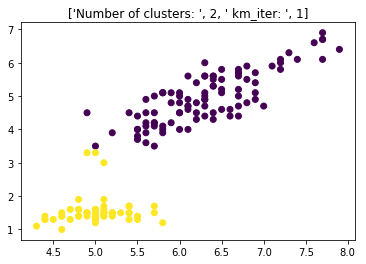

Adjusted rand Index:  0.920405050902
V measure score:  0.870385156563
Calinski Harabaz Score:  513.303843352





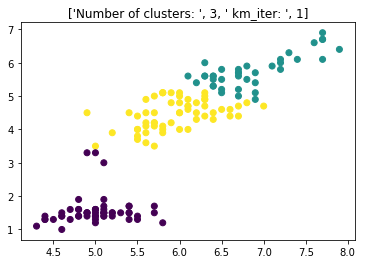

Adjusted rand Index:  0.535514897167
V measure score:  0.6511584715
Calinski Harabaz Score:  520.633406372





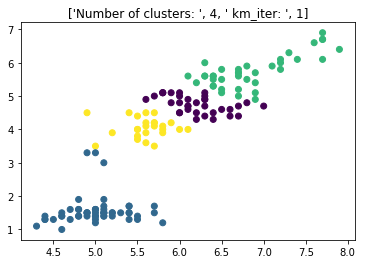

Adjusted rand Index:  0.397680963527
V measure score:  0.563318197514
Calinski Harabaz Score:  427.250677562





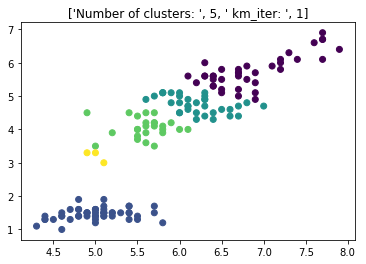

Adjusted rand Index:  0.424800142716
V measure score:  0.616819124016
Calinski Harabaz Score:  401.379881054





In [8]:
#check results

print "****** Performance evaluation with Iris dataset *********\n\n\n" 

#load dataset IRIS
f="datasets/iris.arff"
data, meta = arff.loadarff(f)

#initialize data ndarrays data_num
#. data_num to cluster 
#. data_label: ground truth classification

data_num=np.zeros((len(data), len(data[0])-1))
data_label=np.zeros((len(data)))

i=0
for d in data:
    data_num[i,:]=[d[0],d[1],d[2],d[3]]
    if d[4]=="Iris-setosa":
        data_label[i]=0
    if d[4]=="Iris-versicolor":
        data_label[i]=1
    if d[4]=="Iris-virginica":
        data_label[i]=1
                    
    i=i+1   


######### SET wanted_K and km_iter TO PLOT Bisecting K.means results for Iris
wanted_K=3
km_iter=1
plt.figure()

for wanted_K in range(2,6):

    cluster_assingment=Bk_means(data_num,wanted_K,km_iter,0)
    #cluster_assingment=KMeans(wanted_K).fit_predict(data_num)
    plt.title(["Number of clusters: ",wanted_K," km_iter: " , km_iter] )
    #plt.subplot(2,2,wanted_K-1)
    plt.scatter(data_num[:, 0], data_num[:, 2], c=cluster_assingment)
    #plt.text(2, 0.65, ["Adjusted rand Index: " , adjusted_rand_score(data_label.flatten(), cluster_assingment.flatten())])
    #plt.xlabel(meta[0])
    #plt.ylabel(meta[1])
    plt.show()
    print "Adjusted rand Index: " , sk_cluster_m.adjusted_rand_score(data_label.flatten(), cluster_assingment)
    print "V measure score: " , sk_cluster_m.v_measure_score(data_label.flatten(), cluster_assingment)
    print "Calinski Harabaz Score: ", skmetrics.calinski_harabaz_score(data_num, cluster_assingment) 
    print "\n\n"



#### Bisecting Kmeans: Compare algorithm performance to ground truth K=3 (IRIS)


In [12]:

d_Iris_setosa=data_num[np.where(data["class"]=="Iris-setosa")]
d_Iris_versicolor=data_num[np.where(data["class"]=="Iris-versicolor")]
d_Iris_virginica=data_num[np.where(data["class"]=="Iris-virginica")]

cluster_assingment=Bk_means(data_num,3,2,0)

results_c1=data_num[np.where(cluster_assingment[:]==0),:][0]
results_c2=data_num[np.where(cluster_assingment[:]==1),:][0]
results_c3=data_num[np.where(cluster_assingment[:]==2),:][0]


print len(results_c1), "entries were classified in one cluster of which:\n"
sett=set(map(tuple, d_Iris_setosa)).intersection(map(tuple, list(results_c1)))
d=len(sett)
print"Intersection of C1 with Iris setosa ",d
sett=set(map(tuple, d_Iris_versicolor)).intersection(map(tuple, results_c1))
d=len(sett)
print "Intersection of C1 with Iris versicolor ",d
sett=set(map(tuple, d_Iris_virginica)).intersection(map(tuple, results_c1))
d=len(sett)
print "Intersection of C1  with Iris virgini ",d

print "************************************* \n"

print len(results_c2), "entries were classified in one cluster of which:\n"
sett=set(map(tuple, d_Iris_setosa)).intersection(map(tuple, results_c2))
d=len(sett)
print "intersection with Iris setosa ",d
sett=set(map(tuple, d_Iris_versicolor)).intersection(map(tuple, results_c2))
d=len(sett)
print "intersection with Iris versicolor ",d
sett=set(map(tuple, d_Iris_virginica)).intersection(map(tuple, results_c2))
d=len(sett)
print "intersection with Iris virgini ",d

print "************************************* "

print len(results_c3), "entries were classified in one cluster of which:\n"
sett=set(map(tuple, d_Iris_setosa)).intersection(map(tuple, results_c3))
d=len(sett)
print "intersection with Iris setosa ",d
sett=set(map(tuple, d_Iris_versicolor)).intersection(map(tuple, results_c3))
d=len(sett)
print "intersection with Iris versicolor ",d
sett=set(map(tuple, d_Iris_virginica)).intersection(map(tuple, results_c3))
d=len(sett)
print "intersection with Iris virgini\n ",d



53 entries were classified in one cluster of which:

Intersection of C1 with Iris setosa  48
Intersection of C1 with Iris versicolor  3
Intersection of C1  with Iris virgini  0
************************************* 

38 entries were classified in one cluster of which:

intersection with Iris setosa  0
intersection with Iris versicolor  2
intersection with Iris virgini  36
************************************* 
59 entries were classified in one cluster of which:

intersection with Iris setosa  0
intersection with Iris versicolor  45
intersection with Iris virgini
  13


In [13]:
#### Bisecting Kmeans: Compare algorithm performance to ground truth K=3 (BALANCE)

In [19]:
print "****** Performance evaluation with Balance dataset *********\n\n\n" 

#f = StringIO(content)
f="datasets/bal.arff"
data, meta = arff.loadarff(f)

print len(data)
a=[]

data_num=np.zeros((len(data), len(data[0])-1))
data_label=np.zeros((len(data)))

i=0
for d in data:
    data_num[i,:]=[d[0],d[1],d[2],d[3]]
    if d[4]=="Iris-setosa":
        data_label[i]=0
    if d[4]=="Iris-versicolor":
        data_label[i]=1
    if d[4]=="Iris-virginica":
        data_label[i]=1
                    
    i=i+1    


d_L=data_num[np.where(data["class"]=="L")]
d_B=data_num[np.where(data["class"]=="B")]
d_R=data_num[np.where(data["class"]=="R")]


cluster_assingment=Bk_means(data_num,3,2,0)

results_c1=data_num[np.where(cluster_assingment[:]==0),:][0]
results_c2=data_num[np.where(cluster_assingment[:]==1),:][0]
results_c3=data_num[np.where(cluster_assingment[:]==2),:][0]


print "There are", len(d_L) ,"entries classified as L in Bal data file"
print "There are", len(d_B) ,"entries classified as B in Bal data file."
print "There are", len(d_R) ,"entries classified as R in Bal data file.\n"

print len(results_c1), "entries were classified in one cluster of which:\n"
sett=set(map(tuple, d_L)).intersection(map(tuple, list(results_c1)))
d=len(sett)
print"Intersection of C1 with Balance L ",d
sett=set(map(tuple, d_B)).intersection(map(tuple, results_c1))
d=len(sett)
print "Intersection of C1 with Balance B ",d
sett=set(map(tuple, d_R)).intersection(map(tuple, results_c1))
d=len(sett)
print "Intersection of C1  with Balance R ",d

print "************************************* \n"

print len(results_c2), "entries were classified in one cluster of which:\n"
sett=set(map(tuple, d_L)).intersection(map(tuple, results_c2))
d=len(sett)
print "intersection with Balance L ",d
sett=set(map(tuple, d_B)).intersection(map(tuple, results_c2))
d=len(sett)
print "intersection with Balance B ",d
sett=set(map(tuple, d_R)).intersection(map(tuple, results_c2))
d=len(sett)
print "intersection with Balance R ",d

print "************************************* "

print len(results_c3), "entries were classified in one cluster of which:\n"
sett=set(map(tuple, d_L)).intersection(map(tuple, results_c3))
d=len(sett)
print "intersection with Balance L ",d
sett=set(map(tuple, d_B)).intersection(map(tuple, results_c3))
d=len(sett)
print "intersection with Balance B ",d
sett=set(map(tuple, d_R)).intersection(map(tuple, results_c3))
d=len(sett)
print "intersection with Balance R ",d

print "\n\n"

print "Adjusted rand Index: " , sk_cluster_m.adjusted_rand_score(data_label.flatten(), cluster_assingment)
print "V measure score: " , sk_cluster_m.v_measure_score(data_label.flatten(), cluster_assingment)
print "Calinski Harabaz Score: ", skmetrics.calinski_harabaz_score(data_num, cluster_assingment) 
print "\n\n"

****** Performance evaluation with Balance dataset *********



625
There are 288 entries classified as L in Bal data file
There are 49 entries classified as B in Bal data file.
There are 288 entries classified as R in Bal data file.

162 entries were classified in one cluster of which:

Intersection of C1 with Balance L  149
Intersection of C1 with Balance B  7
Intersection of C1  with Balance R  6
************************************* 

310 entries were classified in one cluster of which:

intersection with Balance L  75
intersection with Balance B  25
intersection with Balance R  210
************************************* 
153 entries were classified in one cluster of which:

intersection with Balance L  64
intersection with Balance B  17
intersection with Balance R  72



Adjusted rand Index:  0.0
V measure score:  -1.70433894578e-15
Calinski Harabaz Score:  122.127699482



